# Task 1

## Decision Tree Visualization with Varying Parameters

> **Note:** This notebook is using the cleaned and VIF reduced dataset from `hw01` unless stated otherwise.

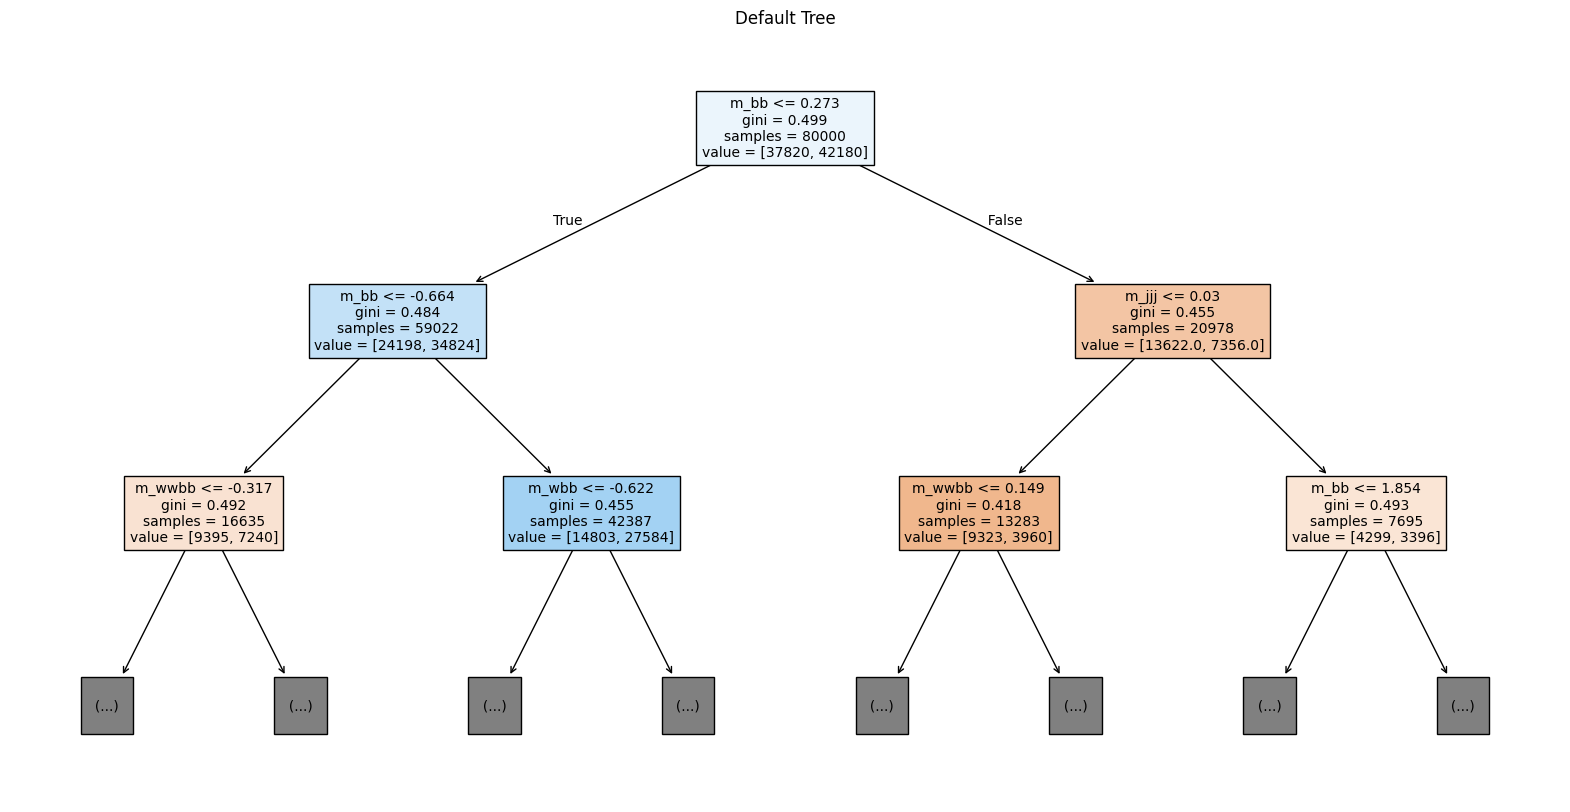

Default Tree - Actual Tree Depth: 45



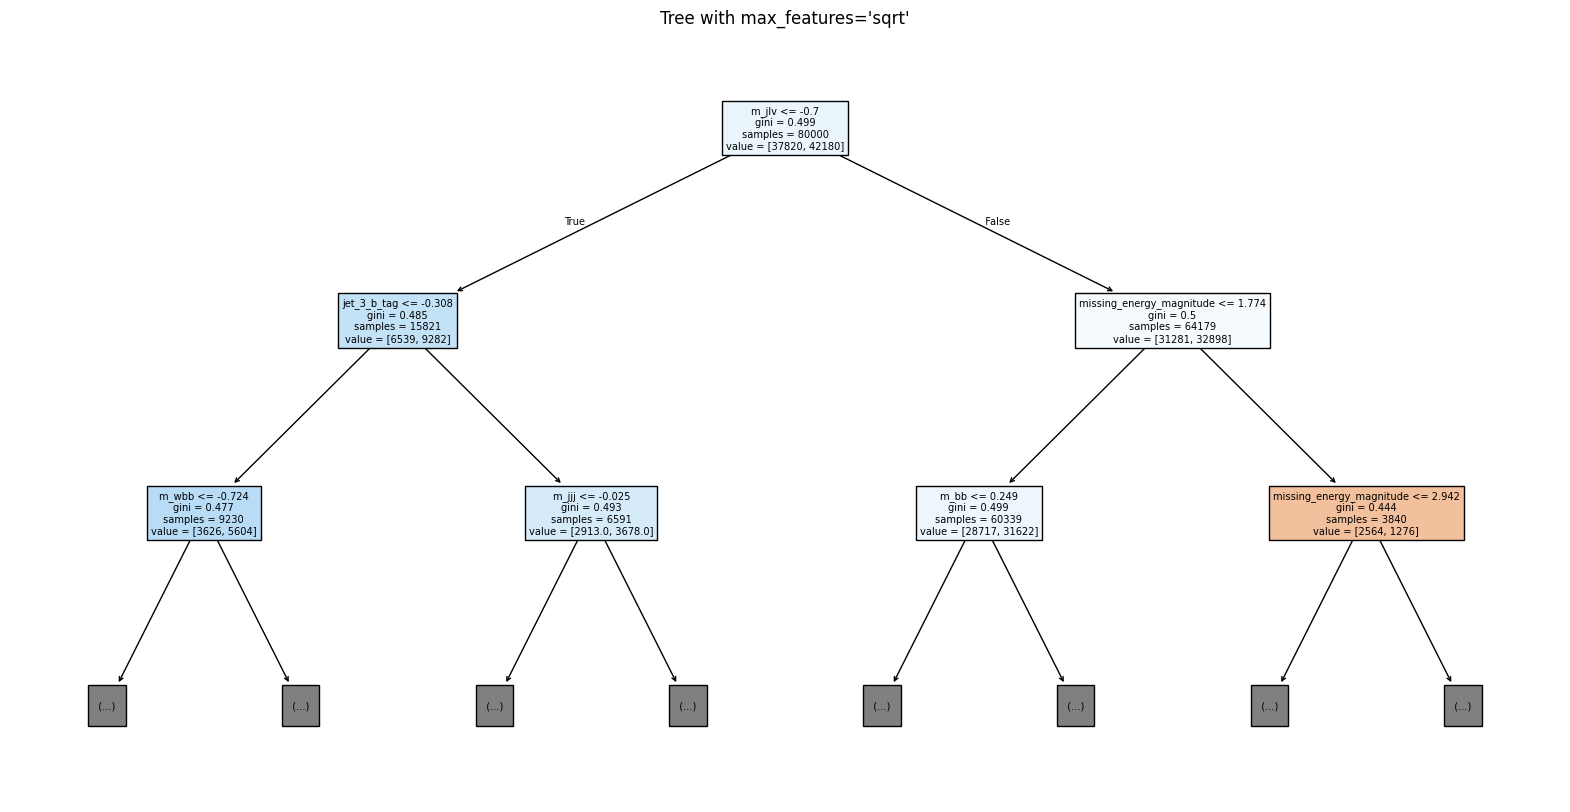

Tree with max_features='sqrt' - Actual Tree Depth: 44



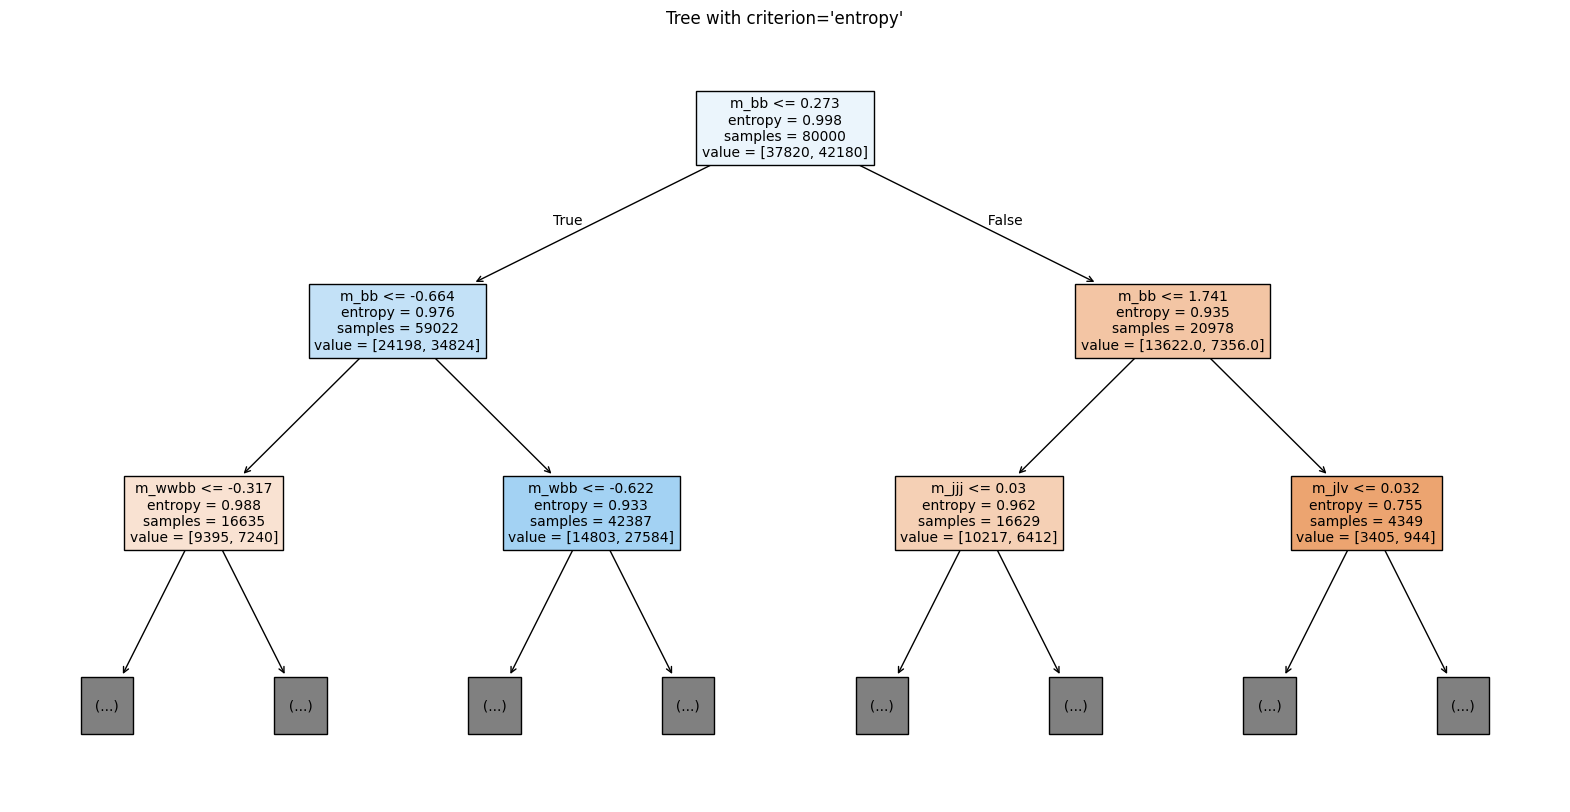

Tree with criterion='entropy' - Actual Tree Depth: 34



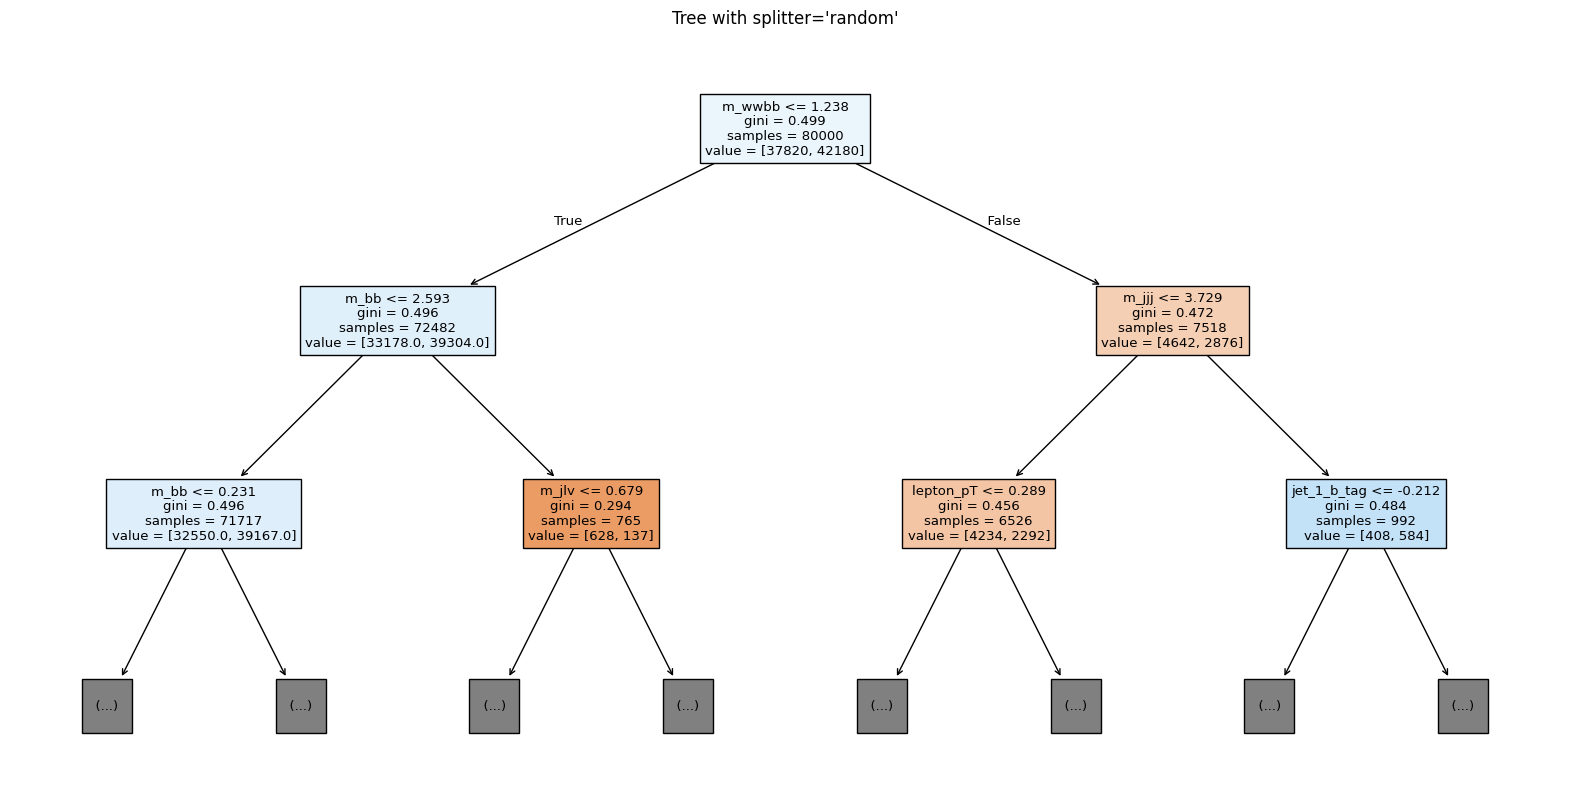

Tree with splitter='random' - Actual Tree Depth: 38



In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree # see reference[2]
from sklearn.model_selection import train_test_split # see reference [3]

# Load the cleaned HIGGS data
data = pd.read_csv("data/HIGGS_subset_clean.csv")
y = data["target"]
X = data.drop(columns=["target"])

rand_state = 42 + 42 # We will use and random state of 42 + 42 this time for 2x the answer to the universe 
max_dep = 100 # Set a very high (and unrealistic) max depth so we can see how changing parameters changes the trees

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Initialize classifiers with different parameters
tree_default = DecisionTreeClassifier(max_depth=max_dep, random_state=rand_state)
tree_max_features = DecisionTreeClassifier(max_depth=max_dep, max_features='sqrt', random_state =rand_state)
tree_criterion = DecisionTreeClassifier(max_depth=max_dep, criterion='entropy', random_state=rand_state)
tree_splitter = DecisionTreeClassifier(max_depth=max_dep, splitter='random', random_state=rand_state)

# Fit classifiers
tree_default.fit(X_train, y_train)
tree_max_features.fit(X_train, y_train)
tree_criterion.fit(X_train, y_train)
tree_splitter.fit(X_train, y_train)

# Plot trees
def plot(tree, title):
    plt.figure(figsize=(20, 10))
    plot_tree(tree, filled=True, feature_names=X.columns, max_depth=2)  # We will display to a max depth of 2 for readability
    plt.title(title)
    plt.show()
    print(f"{title} - Actual Tree Depth: {tree.get_depth()}\n")

# Display trees and depth
plot(tree_default, "Default Tree")
plot(tree_max_features, "Tree with max_features='sqrt'")
plot(tree_criterion, "Tree with criterion='entropy'")
plot(tree_splitter, "Tree with splitter='random'")


### How do the changed parameters affect the tree structure? (see reference [2])

1. **Tree Depth**  
   Setting a higher `max_depth` allows the tree to explore more detailed decision boundaries so it can capture complex patterns in the training data. However, as discussed in class, one downside of this is deeper trees are also more prone to overfitting. This can be especially true if the data has a lot of noise. The default tree reached a depth of **45**.

2. **`max_features='sqrt'`**  
   This restricts the number of features considered at each split which will add randomness and potentially reduce overfitting. It should be noted that this does not stop the split until at least one valid partition of the node samples is found (even if it has to go over `max_features` features). The resulting tree had a depth of **44** which is only 1 less than the default. This suggesting that `max_features` alone may not strongly limit growth unless combined with other constraints.

3. **`criterion='entropy'`**  
   Using **entropy** instead of **gini** for the splitting gave us a max depth of **34**. This indicates that using entropy as a decision method may create more pupurerer early splits that reduce the need for deeper branches.

4. **`splitter='random'`**  
   Using `random` for the `splitter` criterion introduced randomness in the choice of splits by choosing among the best candidates at random. As you can expect, this can lead to less optimal and more irregular trees. This may result in a slightly shallower tree or one with unusual structure* depending on the randomness. The tree with a random splitter reached a depth of **38**.


## Sensitivity Analysis (see reference [4])

Sensitivity analysis is a process used to explore how changes in input variables affect the outputs of a model. Sensitivity analysis evaluates the model's behavior across a broad, fixed range of input values without probabilistic assumptions. The goal is to identify which features have the most influence on the model's predictions. Sensitivity analysis returns a **range of output values** for each combination of inputs, rather than a single expected result or distribution.

### Steps to Take (see reference [4])

For the model given by:

$$
y = f(X)
$$

$$
X = [x_1, x_2, \ldots, x_n]
$$

**Where:**

- **y**: Model output  
- **X**: Model input matrix  
- **xᵢ**: Value of the *i*th *x* variable  

1. Choose a set of values for each $x_i$  
2. Take the Cartesian product of these values as $[X_1, X_2, \ldots, X_m]$  
3. For each $X_i$, calculate $y_i = f(X_i)$  
4. Store the values of $X_i$ mapped to $y_i$  
5. Visualize $y_i$ versus $X_i$  

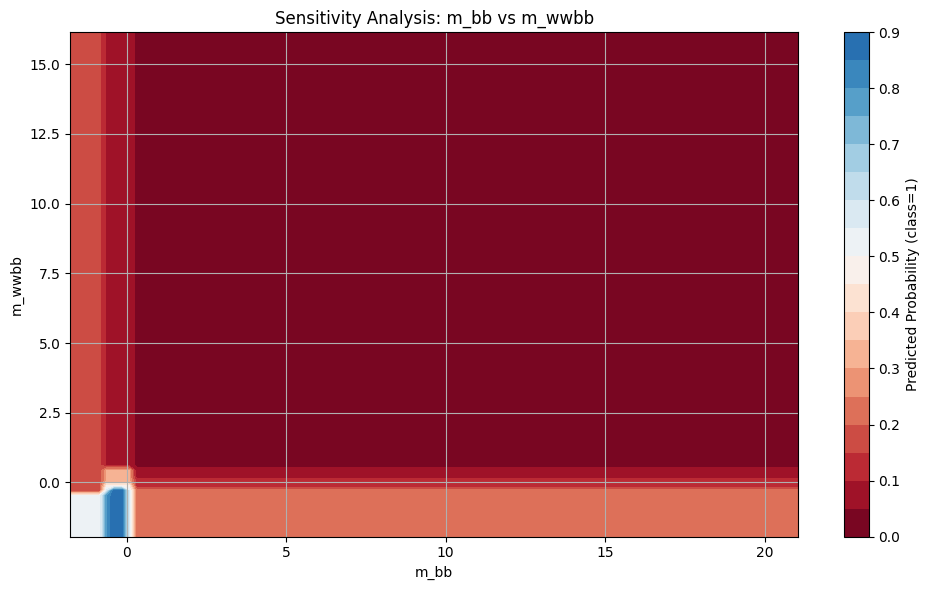

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

# Create a regular decision tree for this analysis
tree = DecisionTreeClassifier(max_depth=10, random_state=rand_state)
tree.fit(X_train, y_train)

# Select two features
feature_1 = 'm_bb'
feature_2 = 'm_wwbb'

# Use median values as baseline
X_ref = X_train.median().to_frame().T

# Define ranges for the top features
f1_vals = np.linspace(X[feature_1].min(), X[feature_1].max(), 100)
f2_vals = np.linspace(X[feature_2].min(), X[feature_2].max(), 100)
f1_grid, f2_grid = np.meshgrid(f1_vals, f2_vals)
probs = np.zeros_like(f1_grid)

# Fill probability values from the model
for i in range(f1_grid.shape[0]):
    for j in range(f1_grid.shape[1]):
        row = X_ref.copy()
        row.at[0, feature_1] = f1_grid[i, j]
        row.at[0, feature_2] = f2_grid[i, j]
        probs[i, j] = tree.predict_proba(row)[0, 1]

# Plot the results
plt.figure(figsize=(10, 6))
cp = plt.contourf(f1_vals, f2_vals, probs, levels=20, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(cp, label='Predicted Probability (class=1)')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.title(f"Sensitivity Analysis: {feature_1} vs {feature_2}")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Analysis

The sensitivity analysis shows that the model assigns high signal probability only in a narrow region where both `m_bb` and `m_wwbb` are very low. If we move outside of this area, the predicted probability quickly drops to near zero and zero values which indicates that these features strongly influence the model’s decision boundary.


# Task 2

## Implementing RandomTree and XGBoost

> Note: Used reference [5] for k-fold cross valadation and used reference[6] for learning about the math behind `XGBoost` and how to implement it.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import time
import tracemalloc  
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score


# Random state
rand_state = 42 + 42

# Load the cleaned HIGGS data
data = pd.read_csv("data/HIGGS_subset_clean.csv")
y = data["target"]
X = data.drop(columns=["target"])

# Define models
rf_model = RandomForestClassifier(n_estimators=100, random_state=rand_state)
gb_model = XGBClassifier(
    n_estimators=100,
    tree_method='hist',
    device='cuda',
    eval_metric='logloss',
    random_state=rand_state
)

# Function to evaluate a model preformance
def evaluate_model_kfold(model, X, y, k):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=rand_state)
    accuracy_scores, precision_scores, f1_scores = [], [], []

    start_time = time.time()
    tracemalloc.start()

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    elapsed_time = time.time() - start_time

    return {
        "Accuracy": np.mean(accuracy_scores),
        "Precision": np.mean(precision_scores),
        "F1 Score": np.mean(f1_scores),
        "Runtime (s)": round(elapsed_time, 3),
        "Peak Memory (MB)": round(peak / 1_000_000, 3)
    }

# Evaluate both models across k folds of 5, 10, 15
fold_sizes = [5, 10, 15]
all_results = []

for k in fold_sizes:
    rf_result = evaluate_model_kfold(rf_model, X, y, k)
    rf_result.update({"Model": "Random Forest", "Folds": k})
    all_results.append(rf_result)

    gb_result = evaluate_model_kfold(gb_model, X, y, k)
    gb_result.update({"Model": "XGBoost", "Folds": k})
    all_results.append(gb_result)

# Display as Dataframe
results_df = pd.DataFrame(all_results)
results_df

# Task 3

## References

1. Murphy, K. P. (2022). *Probabilistic Machine Learning: An Introduction*. MIT Press.  
   Retrieved from https://www.cs.ubc.ca/~murphyk/PMLbook/book1.html

2. scikit-learn developers. (n.d.). *sklearn.tree.DecisionTreeClassifier* — Scikit-learn 1.4.2 documentation.  
   Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

3. scikit-learn developers. (n.d.). *sklearn.tree.plot_tree* — Scikit-learn 1.4.2 documentation.  
   Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

4. DeRobertis, N. (n.d.). *Sensitivity Analysis in Python*.  
Retrieved from https://nickderobertis.github.io/sensitivity/auto_examples/sensitivity_analysis.html

5. GeeksforGeeks. (n.d.). *Stratified K-Fold Cross-Validation*.  
   Retrieved from https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
   
6. XGBoost Developers. (n.d.). *XGBoost Documentation*.  
   Retrieved from https://xgboost.readthedocs.io/en/stable/index.html



